In [1]:
import warnings
from collections import Counter # 统计

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris # 数据集
from sklearn.tree import DecisionTreeClassifier # 决策树 分类
from sklearn.tree import plot_tree # 画决策树
from sklearn.model_selection import train_test_split # 划分数据集
from sklearn.tree import DecisionTreeRegressor # 决策树 回归
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV # 网格搜索交叉验证 给定的超参数范围内寻找最佳的超参数组合

warnings.filterwarnings("ignore")  # 抑制所有警告
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

# 决策树的分类任务

## 二分类的熵和基尼系数

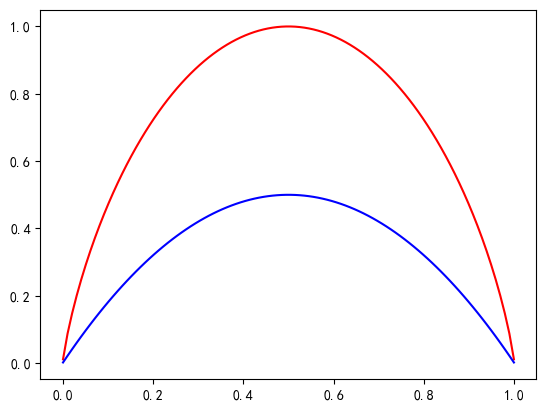

In [2]:
def entropy(p):
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

def gini(p):
    return 1 - p**2 - (1-p)**2

plot_x = np.linspace(0.001,0.999,100)
plt.plot(plot_x,entropy(plot_x),color='red')
plt.plot(plot_x,gini(plot_x),color="blue")
plt.show()

## sklearn的决策树(熵)

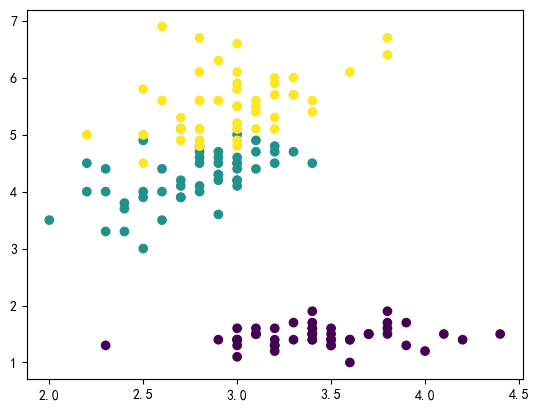

In [3]:
# 加载数据
iris = load_iris()
x = iris.data[:,1:3] # 两个特征维度
y = iris.target

plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

In [4]:
# 决策树的分类模型
clf = DecisionTreeClassifier(max_depth=2,criterion='entropy')
clf.fit(x,y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

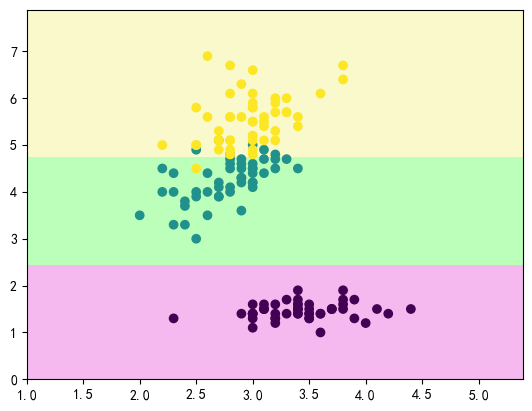

In [5]:
# 决策边界
def decision_boundary_plot(X,y,clf):
    axis_x1_min,axis_x1_max = X[:,0].min()-1, X[:,0].max()+1
    axis_x2_min,axis_x2_max = X[:,1].min()-1, X[:,1].max()+1

    x1,x2 = np.meshgrid(np.arange(axis_x1_min,axis_x1_max,0.01), np.arange(axis_x2_min,axis_x2_max,0.01))
    z = clf.predict(np.c_[x1.ravel(),x2.ravel()])
    z = z.reshape(x1.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#F5B9EF','#BBFFBB','#F9F9CB'])

    plt.contourf(x1,x2,z,cmap=custom_cmap)
    plt.scatter(X[:,0],X[:,1],c=y)
    plt.show()

decision_boundary_plot(x,y,clf)

[Text(0.4, 0.8333333333333334, 'x[1] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.6, 0.5, 'x[1] <= 4.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.154\nsamples = 45\nvalue = [0, 44, 1]'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.497\nsamples = 55\nvalue = [0, 6, 49]')]

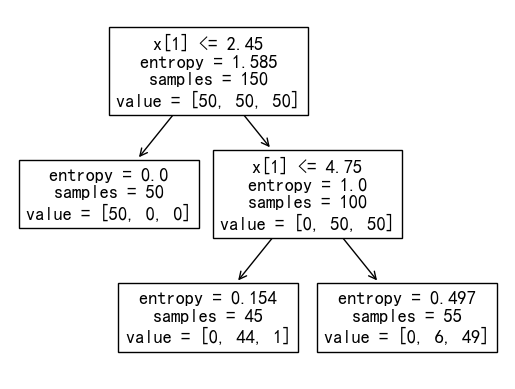

In [6]:
plot_tree(clf) # 查看对应数字

## 最优划分条件

In [7]:
Counter(y)

Counter({0: 50, 1: 50, 2: 50})

In [8]:
def calu_entropy(y):
    counter = Counter(y)
    sum_ent = 0 
    for i in counter:
        p = counter[i] / len(y) # 概率 以频率作为概率
        sum_ent += (-p * np.log2(p))
    return sum_ent

calu_entropy(y)

1.584962500721156

In [9]:
# 分支  分割样本数据
def split_dataset(x,y,dim,value): # 维度(列) 阈值
    index_left = (x[:,dim]<=value) # 左子树
    index_right = (x[:,dim]>value) # 右子树
    return x[index_left],y[index_left],x[index_right],y[index_right]


# 找到最好的特征选择
def find_best_split(x,y):
    best_dim = -1
    best_value = -1
    best_entropy = np.inf
    best_entropy_left, best_entropy_right = -1, -1

    
    for dim in range(x.shape[1]): # 遍历列数
        sorted_index = np.argsort(x[:,dim]) # 先排序再搜索
        
        for i in range(x.shape[0]-1): # 遍历行数
            value_left,value_right = x[sorted_index[i],dim], x[sorted_index[i+1],dim]
            
            if value_left != value_right:
                value = (value_left + value_right) / 2 
                x_left,y_left,x_right,y_right = split_dataset(x,y,dim,value) # 左子树 右子树
                entropy_left,entropy_right = calu_entropy(y_left), calu_entropy(y_right) # 计算左子树右子树的熵
                entropy = (len(x_left)*entropy_left + len(x_right)*entropy_right) / x.shape[0] # 加权平均
    
                if entropy < best_entropy:
                    best_dim = dim
                    best_value = value
                    best_entropy = entropy
                    best_entropy_left = entropy_left
                    best_entropy_right = entropy_right

    return best_dim,best_value,best_entropy,best_entropy_left,best_entropy_right 


best_dim,best_value,best_entropy,best_entropy_left,best_entropy_right = find_best_split(x,y)
print(best_dim,best_value)
x_left,y_left,x_right,y_right = split_dataset(x,y,best_dim,best_value)

best_dim,best_value,best_entropy,best_entropy_left,best_entropy_right = find_best_split(x_right,y_right)
print(best_dim,best_value)

1 2.45
1 4.75


## sklearn的决策树(gini)

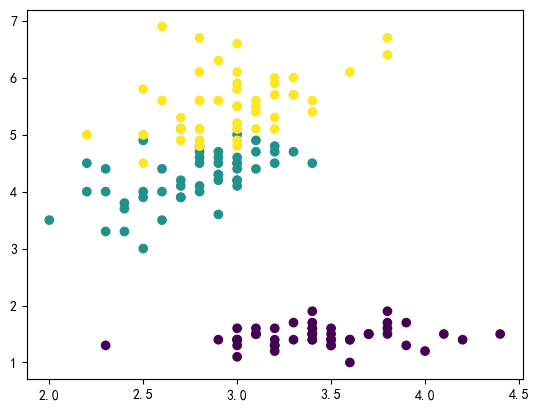

In [10]:
# 加载数据
iris = load_iris()
x = iris.data[:,1:3]
y = iris.target 

plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

In [11]:
# 决策树的分类模型
clf = DecisionTreeClassifier(max_depth=2,criterion='gini') # 默认
clf.fit(x,y)

DecisionTreeClassifier(max_depth=2)

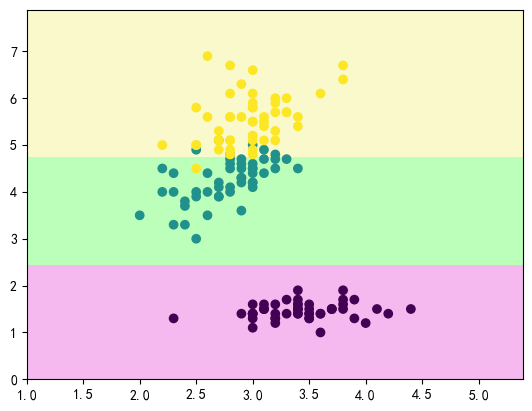

In [12]:
decision_boundary_plot(x, y, clf)

[Text(0.4, 0.8333333333333334, 'x[1] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.6, 0.5, 'x[1] <= 4.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.043\nsamples = 45\nvalue = [0, 44, 1]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.194\nsamples = 55\nvalue = [0, 6, 49]')]

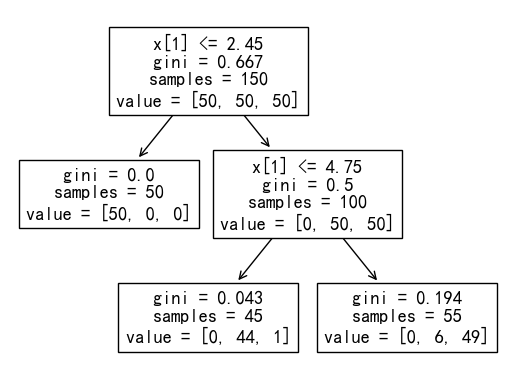

In [13]:
plot_tree(clf)

## 最优划分条件

In [14]:
def calu_gini(y):
    counter = Counter(y)
    sum_gini = 1 
    for i in counter:
        p = counter[i] / len(y)
        sum_gini -= p**2
    return sum_gini

calu_gini(y)

0.6666666666666665

In [15]:
# 分支  分割样本数据
def split_dataset(x,y,dim,value): # 维度(列) 阈值
    index_left = (x[:,dim]<=value) # 左子树
    index_right = (x[:,dim]>value) # 右子树
    return x[index_left],y[index_left],x[index_right],y[index_right]


# 找到最好的特征选择
def find_best_split(x,y):
    best_dim = -1
    best_value = -1
    best_gini = np.inf
    best_gini_left, best_gini_right = -1, -1

    
    for dim in range(x.shape[1]): # 遍历列数
        sorted_index = np.argsort(x[:,dim]) # 先排序再搜索
        
        for i in range(x.shape[0]-1): # 遍历行数
            value_left,value_right = x[sorted_index[i],dim], x[sorted_index[i+1],dim]
            
            if value_left != value_right:
                value = (value_left + value_right) / 2 
                x_left,y_left,x_right,y_right = split_dataset(x,y,dim,value) # 左子树 右子树
                gini_left,gini_right = calu_gini(y_left), calu_gini(y_right) # 计算左子树右子树的熵
                gini = (len(x_left)*gini_left + len(x_right)*gini_right) / x.shape[0] # 加权平均
    
                if gini < best_gini:
                    best_dim = dim
                    best_value = value
                    best_gini = gini
                    best_gini_left = gini_left
                    best_gini_right = gini_right

    return best_dim,best_value,best_gini,best_gini_left,best_gini_right 


best_dim,best_value,best_gini,best_gini_left,best_gini_right = find_best_split(x,y)
print(best_dim,best_value)
x_left,y_left,x_right,y_right = split_dataset(x,y,best_dim,best_value)

best_dim,best_value,best_gini,best_gini_left,best_gini_right = find_best_split(x_right,y_right)
print(best_dim,best_value)

1 2.45
1 4.75


# 决策树的剪枝(训练复杂度过高 容易过拟合)

## 过拟合决策树的模样

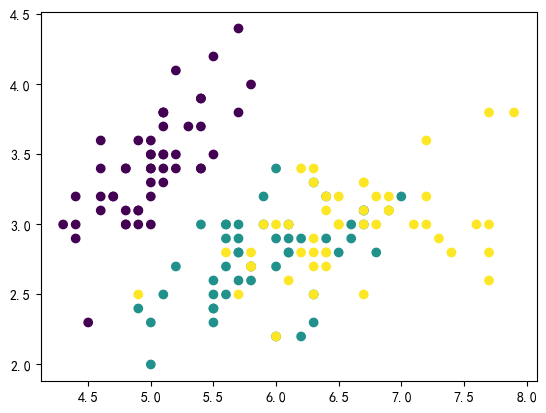

In [16]:
iris = load_iris()
x = iris.data[:,0:2]
y = iris.target

plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

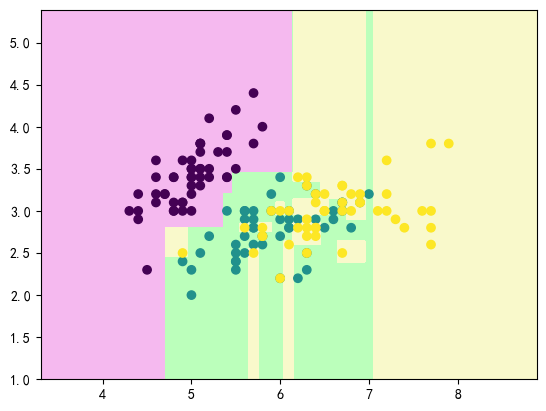

[Text(0.36890243902439024, 0.9615384615384616, 'x[0] <= 5.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.0975609756097561, 0.8846153846153846, 'x[1] <= 2.8\ngini = 0.237\nsamples = 52\nvalue = [45, 6, 1]'),
 Text(0.04878048780487805, 0.8076923076923077, 'x[0] <= 4.7\ngini = 0.449\nsamples = 7\nvalue = [1, 5, 1]'),
 Text(0.024390243902439025, 0.7307692307692307, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.07317073170731707, 0.7307692307692307, 'x[0] <= 4.95\ngini = 0.278\nsamples = 6\nvalue = [0, 5, 1]'),
 Text(0.04878048780487805, 0.6538461538461539, 'x[1] <= 2.45\ngini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.024390243902439025, 0.5769230769230769, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.07317073170731707, 0.5769230769230769, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.0975609756097561, 0.6538461538461539, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0]'),
 Text(0.14634146341463414, 0.8076923076923077, 'x[0] <= 5.35\ngini = 0.

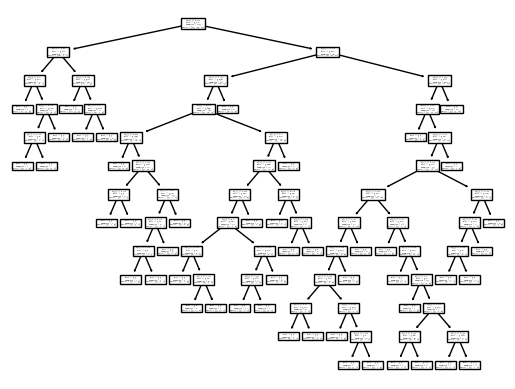

In [17]:
clf = DecisionTreeClassifier()
clf.fit(x,y)

decision_boundary_plot(x,y,clf) # 比较明显的过拟合  过犹不及
plot_tree(clf)

## 剪枝：最大深度、最小样本划分、最小节点样本数、最大叶子节点个数、叶子权重

sklearn中的DecisionTreeClassifier是一个用于构建决策树分类器的类，它具有许多超参数，可以用来调整模型的性能和行为。以下是一些常用的超参数：

criterion：用于衡量分裂质量的标准，通常是"gini"（Gini不纯度）或"entropy"（信息熵）。

splitter：用于选择节点分裂策略的方法，通常是"best"（选择最佳分裂点）或"random"（随机选择分裂点）。

<font color='red'>max_depth：树的最大深度，用于控制树的复杂性和过拟合。</font>

<font color='red'>min_samples_split：分裂一个内部节点所需的最小样本数。</font>

<font color='red'>min_samples_leaf：叶子节点所需的最小样本数。</font>

<font color='red'>min_weight_fraction_leaf：叶子节点的最小权重分数，用于加权样本。</font>

max_features：寻找最佳分裂点时考虑的特征数量。  

<font color='red'>max_leaf_nodes：叶子节点的最大数量。</font>    

min_impurity_decrease：分裂一个节点所需的最小不纯度减少量。

class_weight：用于处理类别不平衡问题的类别权重。

random_state：用于控制随机性的随机种子。om_state：用于控制随机性的随机种子。

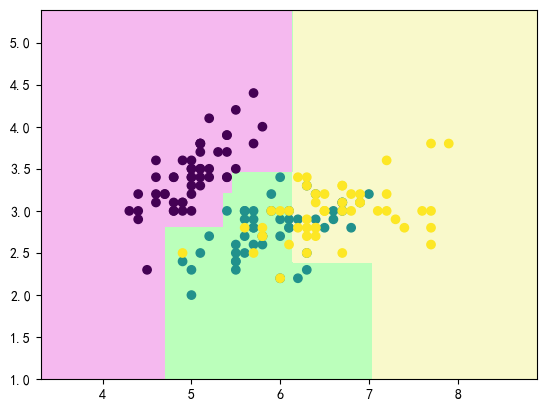

[Text(0.5, 0.9, 'x[0] <= 5.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2222222222222222, 0.7, 'x[1] <= 2.8\ngini = 0.237\nsamples = 52\nvalue = [45, 6, 1]'),
 Text(0.1111111111111111, 0.5, 'x[0] <= 4.7\ngini = 0.449\nsamples = 7\nvalue = [1, 5, 1]'),
 Text(0.05555555555555555, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.16666666666666666, 0.3, 'x[0] <= 4.95\ngini = 0.278\nsamples = 6\nvalue = [0, 5, 1]'),
 Text(0.1111111111111111, 0.1, 'gini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.2222222222222222, 0.1, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0]'),
 Text(0.3333333333333333, 0.5, 'x[0] <= 5.35\ngini = 0.043\nsamples = 45\nvalue = [44, 1, 0]'),
 Text(0.2777777777777778, 0.3, 'gini = 0.0\nsamples = 39\nvalue = [39, 0, 0]'),
 Text(0.3888888888888889, 0.3, 'x[1] <= 3.2\ngini = 0.278\nsamples = 6\nvalue = [5, 1, 0]'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4444444444444444, 0.1, 'gini = 0.0\nsamples

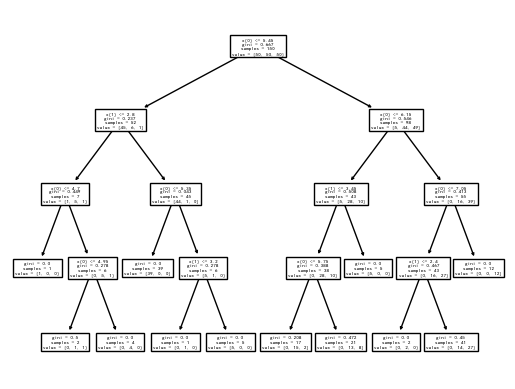

In [18]:
clf = DecisionTreeClassifier(max_depth=4) # 设置超参数  最大深度
clf.fit(x, y)
decision_boundary_plot(x, y, clf)
plot_tree(clf)

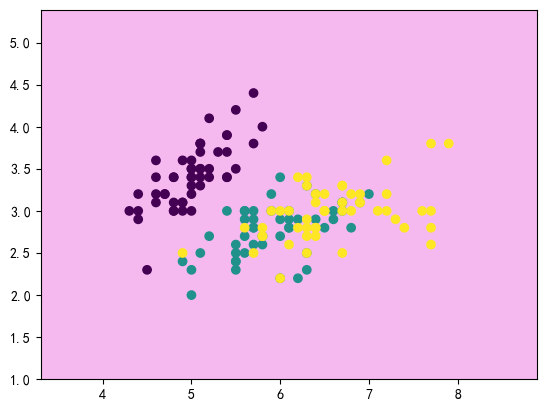

[Text(0.5, 0.5, 'gini = 0.667\nsamples = 150\nvalue = [50, 50, 50]')]

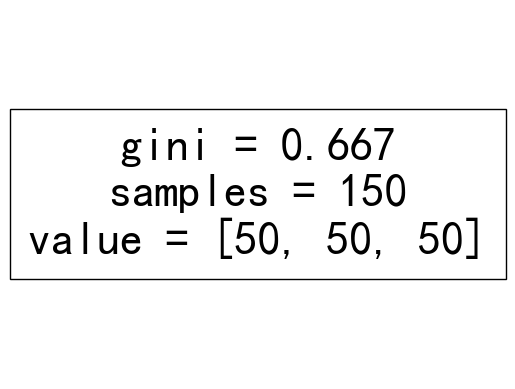

In [19]:
clf =DecisionTreeClassifier(min_samples_split=151) # 设置超参数  最小样本划分【不能太大】
clf.fit(x,y)
decision_boundary_plot(x,y,clf)
plot_tree(clf)

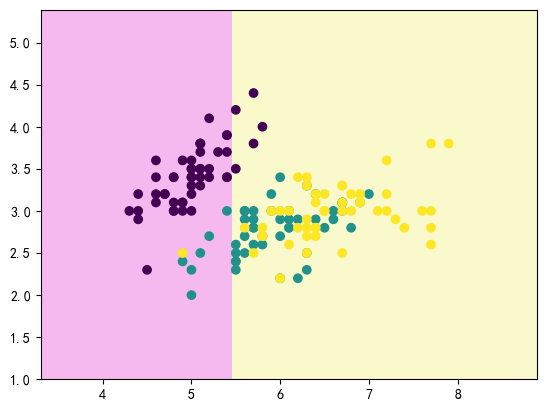

[Text(0.5, 0.75, 'x[0] <= 5.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.25, 0.25, 'gini = 0.237\nsamples = 52\nvalue = [45, 6, 1]'),
 Text(0.75, 0.25, 'gini = 0.546\nsamples = 98\nvalue = [5, 44, 49]')]

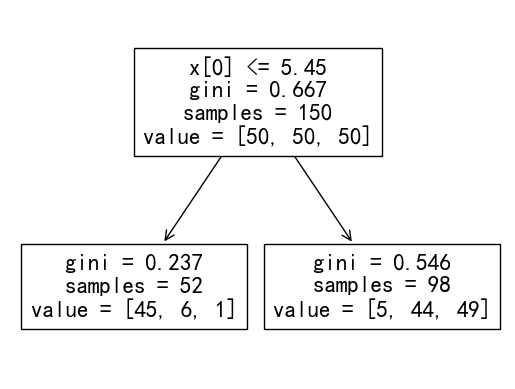

In [20]:
clf =DecisionTreeClassifier(min_samples_leaf=50) # 设置超参数  最小节点样本数【不能太大】
clf.fit(x,y)
decision_boundary_plot(x,y,clf)
plot_tree(clf)

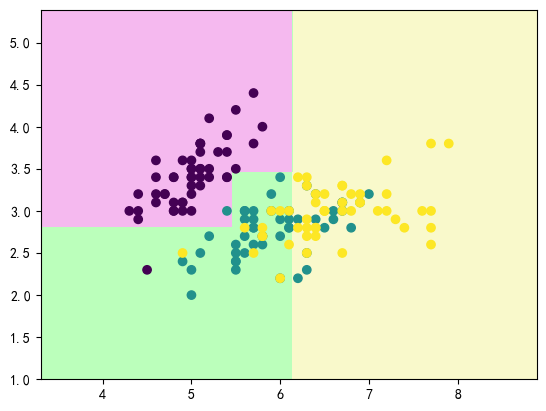

[Text(0.4090909090909091, 0.875, 'x[0] <= 5.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.18181818181818182, 0.625, 'x[1] <= 2.8\ngini = 0.237\nsamples = 52\nvalue = [45, 6, 1]'),
 Text(0.09090909090909091, 0.375, 'gini = 0.449\nsamples = 7\nvalue = [1, 5, 1]'),
 Text(0.2727272727272727, 0.375, 'gini = 0.043\nsamples = 45\nvalue = [44, 1, 0]'),
 Text(0.6363636363636364, 0.625, 'x[0] <= 6.15\ngini = 0.546\nsamples = 98\nvalue = [5, 44, 49]'),
 Text(0.45454545454545453, 0.375, 'x[1] <= 3.45\ngini = 0.508\nsamples = 43\nvalue = [5, 28, 10]'),
 Text(0.36363636363636365, 0.125, 'gini = 0.388\nsamples = 38\nvalue = [0, 28, 10]'),
 Text(0.5454545454545454, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [5, 0, 0]'),
 Text(0.8181818181818182, 0.375, 'x[0] <= 7.05\ngini = 0.413\nsamples = 55\nvalue = [0, 16, 39]'),
 Text(0.7272727272727273, 0.125, 'gini = 0.467\nsamples = 43\nvalue = [0, 16, 27]'),
 Text(0.9090909090909091, 0.125, 'gini = 0.0\nsamples = 12\nvalue = [0, 0, 12]')]

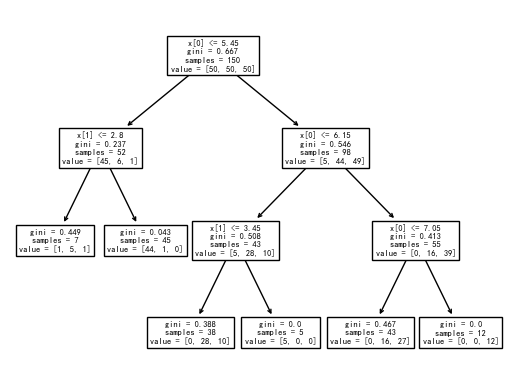

In [21]:
clf =DecisionTreeClassifier(max_leaf_nodes=6) # 设置超参数  最大叶子节点个数
clf.fit(x,y)
decision_boundary_plot(x,y,clf)
plot_tree(clf)

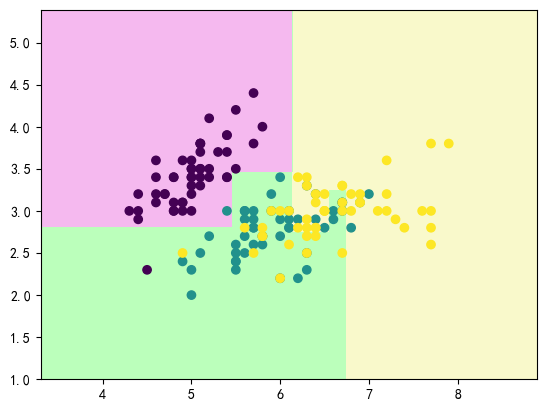

[Text(0.3684210526315789, 0.9375, 'x[0] <= 5.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.10526315789473684, 0.8125, 'x[1] <= 2.8\ngini = 0.237\nsamples = 52\nvalue = [45, 6, 1]'),
 Text(0.05263157894736842, 0.6875, 'gini = 0.449\nsamples = 7\nvalue = [1, 5, 1]'),
 Text(0.15789473684210525, 0.6875, 'x[0] <= 5.35\ngini = 0.043\nsamples = 45\nvalue = [44, 1, 0]'),
 Text(0.10526315789473684, 0.5625, 'gini = 0.0\nsamples = 39\nvalue = [39, 0, 0]'),
 Text(0.21052631578947367, 0.5625, 'gini = 0.278\nsamples = 6\nvalue = [5, 1, 0]'),
 Text(0.631578947368421, 0.8125, 'x[0] <= 6.15\ngini = 0.546\nsamples = 98\nvalue = [5, 44, 49]'),
 Text(0.3684210526315789, 0.6875, 'x[1] <= 3.45\ngini = 0.508\nsamples = 43\nvalue = [5, 28, 10]'),
 Text(0.3157894736842105, 0.5625, 'x[0] <= 5.75\ngini = 0.388\nsamples = 38\nvalue = [0, 28, 10]'),
 Text(0.21052631578947367, 0.4375, 'x[0] <= 5.55\ngini = 0.208\nsamples = 17\nvalue = [0, 15, 2]'),
 Text(0.15789473684210525, 0.3125, 'gini = 0.0\n

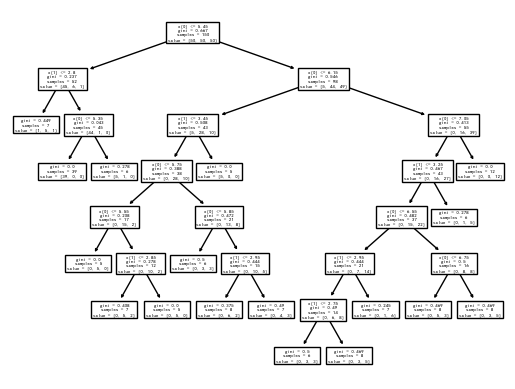

In [22]:
clf =DecisionTreeClassifier(min_weight_fraction_leaf=0.03) # 设置超参数  
clf.fit(x,y)
decision_boundary_plot(x,y,clf)
plot_tree(clf)

## 网格搜索：超参数组合使用

# 决策树的回归任务

## 加载数据

In [23]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

x = data
y = target

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=233)

## 决策树的回归

In [24]:
reg = DecisionTreeRegressor()
reg.fit(x_train,y_train)

print(reg.score(x_train,y_train))
print(reg.score(x_test,y_test)) # 非常明显的过拟合

1.0
0.7142980532743839


## 学习曲线

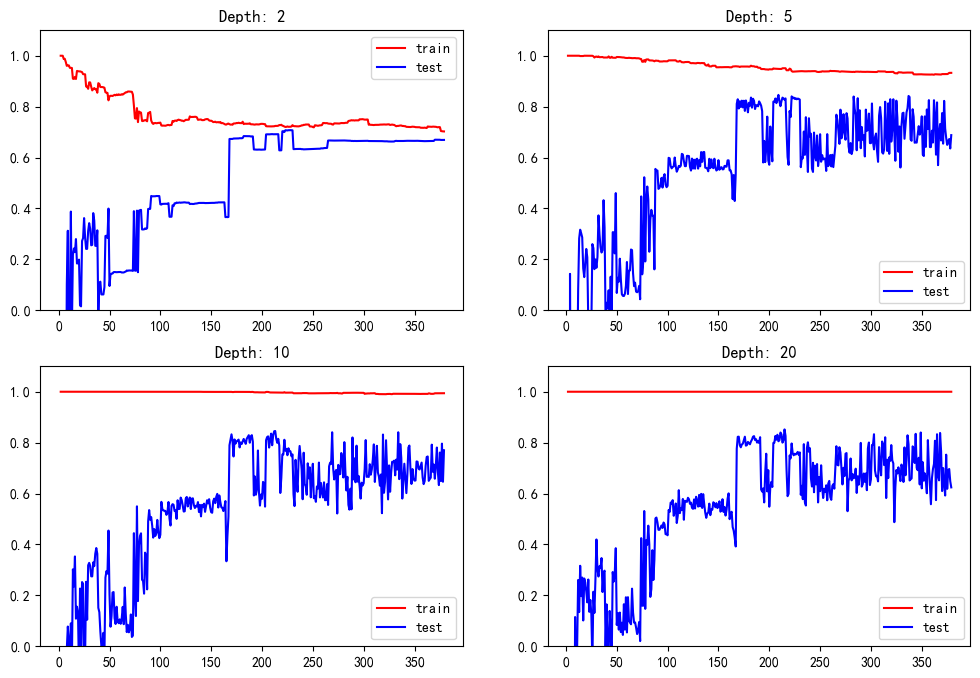

In [25]:
plt.rcParams['figure.figsize'] = (12,8)
max_depth = [2,5,10,20]

for i,depth in enumerate(max_depth):
    reg = DecisionTreeRegressor(max_depth=depth)
    train_error,test_error = [],[]

    for k in range(len(x_train)):
        reg.fit(x_train[:k+1],y_train[:k+1])
        
        y_train_pred = reg.predict(x_train[:k+1])
        train_error.append(r2_score(y_train[:k+1],y_train_pred))

        y_test_pred = reg.predict(x_test)
        test_error.append(r2_score(y_test,y_test_pred))

    plt.subplot(2,2,i+1)
    plt.ylim(0,1.1)
    plt.title('Depth: {0}'.format(depth))
    plt.plot([k+1 for k in range(len(x_train))],train_error, color='red', label='train')
    plt.plot([k+1 for k in range(len(x_train))], test_error, color='blue', label='test')
    plt.legend()

plt.show()

## 网格搜索

In [26]:
params = {
    'max_depth': [n for n in range(2,15)],
    'min_samples_leaf': [sn for sn in range(3,20)],
}

grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=params,
    n_jobs=-1
)

grid.fit(x_train,y_train)

print(grid.best_params_)
print(grid.best_score_) # 0.7254910516550357  在训练数据集上进行K-fold cross-validation时得到的平均性能得分 

{'max_depth': 5, 'min_samples_leaf': 3}
0.7327442904059717


In [27]:
reg = grid.best_estimator_ # 最好的模型
reg.score(x_test,y_test) # 0.7996840631011902

0.7867563472177268

# 决策树的缺点：不稳定

In [33]:
iris = load_iris()
X = iris.data[:,2:] # 后两列特征
y = iris.target

dt_clf = DecisionTreeClassifier(max_depth=2,random_state=666)
dt_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2, random_state=666)

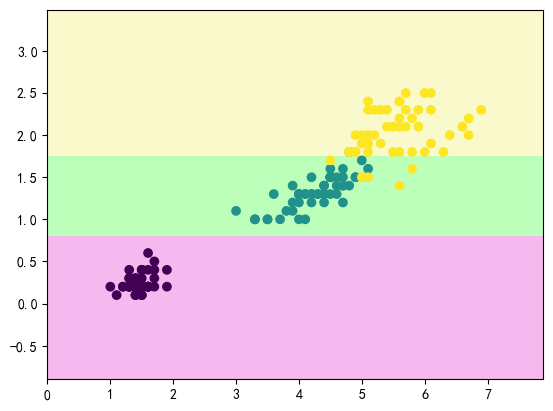

In [34]:
plt.rcParams['figure.figsize'] = [6.4, 4.8]  # 默认的宽度和高度
decision_boundary_plot(X,y,dt_clf) # 画出决策边界

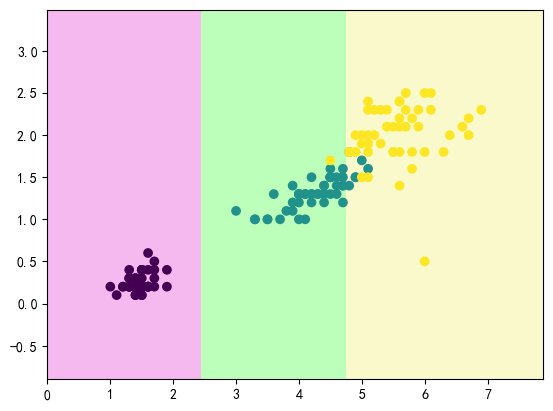

In [35]:
# 只改变一点点
X[130] = [6, 0.5]
dt_clf.fit(X, y)
decision_boundary_plot(X,y,dt_clf) 